# Перевалов Александр Дмитриевич 19-ИВТ-3

## Лабораторная работа №4

### Вариант №6 "mpg"




In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import (cross_val_score, StratifiedKFold,
                                     train_test_split)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from scipy.stats import pearsonr, spearmanr

### 1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

Данные описывают потребление топлива в милях на галон(mpg) у разных автомобилей, что должно быть предсказано с точки зрения 3-х многозначных дискретных и 5-и вещественных атрибутов.

|  Переменная  | Описание  | Параметр  | 
|--------------|--------------|-------------------|
|      mpg     |потребление топлива  | вещественный|
|   cylinders  | число цилиндров|дискретный|
| displacement |литраж|вещественный|
|  horsepower  |мощность|вещественный|
|    weight    |вес|вещественный|
| acceleration |ускорение|вещественный|
|  model year  |год выпуска|дискретный|
|    origin    |место производства|дискретный|
|   car name   |название модели|строка(уникальная)|

In [2]:
df = pd.read_csv('auto-mpg.data.txt', sep='\s+', names=["mpg",
                                                        "cylinders",
                                                        "displacement",
                                                        "horsepower",
                                                        "weight",
                                                        "acceleration",
                                                        "model_year",
                                                        "origin",
                                                        "car_name"])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Можем смело убрать столбец **car name** из датасета, так как он не пригодится при решении задачи регрессии.

In [3]:
df.drop('car_name', axis=1, inplace=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


Приведём столбец **horsepower** к типу float

In [5]:
df.horsepower = df.horsepower.apply(lambda x: float(x) if x!='?' else None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


Заполним пропуски в данных столбца **horsepower**

In [6]:
df.horsepower = df.horsepower.transform(lambda x: x.fillna(x.mean()))

### 2. Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции

In [7]:
df = df.drop_duplicates()
df = df.dropna().reset_index(drop=True)
print('dataset size: ', df.shape)

dataset size:  (398, 8)


### 3. Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию)

In [8]:
# выделим категориальные и числовые(количественные) признаки
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']
categorial:  []


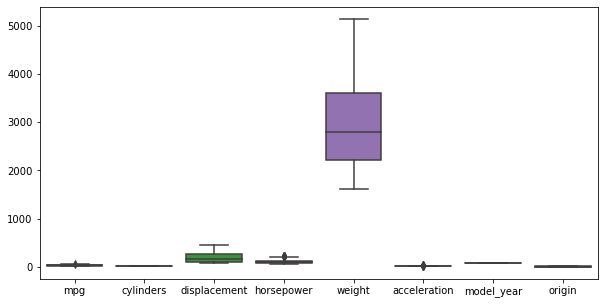

In [9]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df[numerical_columns])
plt.show()

Место производства обозначено через ключи, поэтому оно должно относится к категориальным признакам. Количество цилиндров имеет несколько типов, промежуточные значения не допускаются. Преобразуем эти столбцы к строковому виду.

In [10]:
df['cylinders'] = df['cylinders'].apply(lambda x: str(x))
df['origin'] = df['origin'].apply(lambda x: str(x))

#заново выделим категориальные и числовые
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
categorial:  ['cylinders', 'origin']


В качестве способа масштабирования выберем метод нормализации.

In [11]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,0.239362,8,0.617571,0.456522,0.536150,0.238095,0.0,1
1,0.159574,8,0.728682,0.646739,0.589736,0.208333,0.0,1
2,0.239362,8,0.645995,0.565217,0.516870,0.178571,0.0,1
3,0.186170,8,0.609819,0.565217,0.516019,0.238095,0.0,1
4,0.212766,8,0.604651,0.510870,0.520556,0.148810,0.0,1


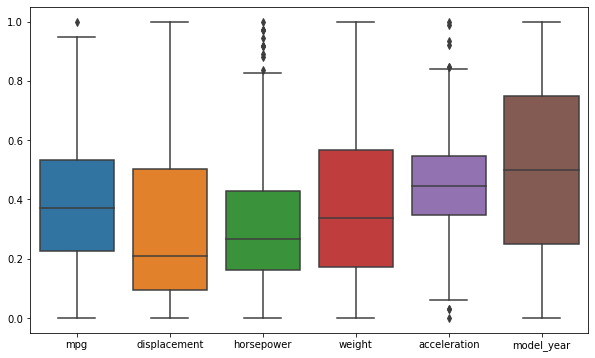

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_columns])
plt.show()

### 4.	Выполните замену категориальных признаков; выберите и обоснуйте способ замены

In [13]:
# выведем уникальные значения 
for i in categorial_columns:
    print(i,': ', df[i].unique())

cylinders :  ['8' '4' '6' '3' '5']
origin :  ['1' '3' '2']


Уникальных значений оказалось не много, поэтмому можно применить dummy-кодирование

In [14]:
df_categorial = pd.get_dummies(df[categorial_columns])
df.drop(categorial_columns, axis=1, inplace=True)
df = pd.concat([df_categorial, df] , axis=1)

print(df.shape)
df.head()

(398, 14)


,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3,mpg,displacement,horsepower,weight,acceleration,model_year
0,0,0,0,0,1,1,0,0,0.239362,0.617571,0.456522,0.536150,0.238095,0.0
1,0,0,0,0,1,1,0,0,0.159574,0.728682,0.646739,0.589736,0.208333,0.0
2,0,0,0,0,1,1,0,0,0.239362,0.645995,0.565217,0.516870,0.178571,0.0
3,0,0,0,0,1,1,0,0,0.186170,0.609819,0.565217,0.516019,0.238095,0.0
4,0,0,0,0,1,1,0,0,0.212766,0.604651,0.510870,0.520556,0.148810,0.0


### 5. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других

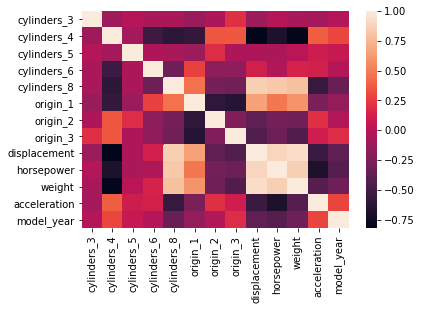

In [15]:
df_corr = df.drop('mpg', axis=1).corr()
sns.heatmap(df_corr)
plt.show()

In [16]:
df_corr

,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3,displacement,horsepower,weight,acceleration,model_year
cylinders_3,1.000000,-0.103323,-0.008781,-0.052114,-0.059537,-0.130253,-0.046547,0.202471,-0.117001,-0.013785,-0.068134,-0.084803,-0.013916
cylinders_4,-0.103323,1.000000,-0.089367,-0.530382,-0.605929,-0.577788,0.358080,0.359268,-0.823494,-0.686643,-0.802992,0.384747,0.295302
cylinders_5,-0.008781,-0.089367,1.000000,-0.045075,-0.051496,-0.112660,0.188647,-0.043369,-0.040525,-0.050566,0.013695,0.096990,0.070558
cylinders_6,-0.052114,-0.530382,-0.045075,1.000000,-0.305620,0.272871,-0.174247,-0.164767,0.122760,-0.039696,0.139308,0.130516,-0.011412
cylinders_8,-0.059537,-0.605929,-0.051496,-0.305620,1.000000,0.457089,-0.272973,-0.294053,0.860098,0.833752,0.799446,-0.560540,-0.337150
origin_1,-0.130253,-0.577788,-0.112660,0.272871,0.457089,1.000000,-0.597198,-0.643317,0.651407,0.486083,0.598398,-0.250806,-0.139883
origin_2,-0.046547,0.358080,0.188647,-0.174247,-0.272973,-0.597198,1.000000,-0.229895,-0.373886,-0.281258,-0.298843,0.204473,-0.024489
origin_3,0.202471,0.359268,-0.043369,-0.164767,-0.294053,-0.643317,-0.229895,1.000000,-0.433505,-0.321325,-0.440817,0.109144,0.193101
displacement,-0.117001,-0.823494,-0.040525,0.122760,0.860098,0.651407,-0.373886,-0.433505,1.000000,0.893646,0.932824,-0.543684,-0.370164
horsepower,-0.013785,-0.686643,-0.050566,-0.039696,0.833752,0.486083,-0.281258,-0.321325,0.893646,1.000000,0.860574,-0.684259,-0.411651


По диаграмме видно, что литраж сильно коррелирует с мощностью, весом, и ускорением. Поэтому удалим этот параметр из датасета

In [17]:
df.drop('displacement', axis=1, inplace=True)

### 6. Заполните пропущенные значения в данных

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders_3   398 non-null    uint8  
 1   cylinders_4   398 non-null    uint8  
 2   cylinders_5   398 non-null    uint8  
 3   cylinders_6   398 non-null    uint8  
 4   cylinders_8   398 non-null    uint8  
 5   origin_1      398 non-null    uint8  
 6   origin_2      398 non-null    uint8  
 7   origin_3      398 non-null    uint8  
 8   mpg           398 non-null    float64
 9   horsepower    398 non-null    float64
 10  weight        398 non-null    float64
 11  acceleration  398 non-null    float64
 12  model_year    398 non-null    float64
dtypes: float64(5), uint8(8)
memory usage: 18.8 KB


Как мы видим - пропущенных значений не обнаружено

### 7.	Решите поставленную задачу регрессии в соответствии с заданием. При подборе параметров метода принятия решения (метода регрессии) используйтеперекрёстную проверку (изучите возможные для изменения параметры метода регрессии). Вычислите точность решения задачи, вычислив разницу между реальным значением и предсказанным. Вычислите коэффициент корреляции (Пирсона, Спирмена) между реальным значением и предсказаннымс учётом p-value
 * 1 - Линейная регрессия без использования регуляризаторов
 * 3 - Линейная регрессия, RIDGE регуляризатор


In [19]:
# разделим полученные данные на данные для обучения и теста
X, y = df.drop('mpg', axis=1), df['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

**Линейная регрессия без использования регуляризаторов**

In [20]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
pred_regr = regr.predict(X_test)
print(pred_regr[:15] - y_test[:15])

198    0.008187
396    0.051321
33    -0.004239
208    0.116273
93    -0.011885
84     0.025183
373    0.110829
94    -0.098570
222    0.045047
126   -0.026180
9     -0.073637
383   -0.038855
56    -0.010721
72    -0.011137
132   -0.019282
Name: mpg, dtype: float64


In [21]:
corr = {}
corr['pearson'], pvalue_pearson = pearsonr(pred_regr, y_test)
corr['spearman'], pvalue_spearman = spearmanr(pred_regr, y_test)
print('pearson correlation: ', corr['pearson'], '   p-value: ', pvalue_pearson)
print('spearmen correlation: ', corr['spearman'], '   p-value: ', pvalue_spearman)

pearson correlation:  0.9301591754329479    p-value:  3.535135978294441e-53
spearmen correlation:  0.949198517938917    p-value:  4.320558294253148e-61


**Линейная регрессия, RIDGE регуляризатор**

In [22]:
import warnings
warnings.filterwarnings("ignore")

regr = linear_model.Ridge()
params = {'alpha': np.arange(0, 3, 0.05)}
regr_grid = GridSearchCV(regr, params)
regr_grid.fit(X_train, y_train)
best_alpha = regr_grid.best_estimator_.alpha
print('best alpha:', best_alpha)

best alpha: 0.30000000000000004


In [23]:
regr = linear_model.Ridge(alpha=best_alpha)
regr.fit(X_train,y_train)
pred_regr = regr.predict(X_test)
print(pred_regr[:15] - y_test[:15])

198    0.001102
396    0.053116
33    -0.004400
208    0.113889
93    -0.007439
84     0.018451
373    0.117183
94    -0.094047
222    0.046295
126   -0.028635
9     -0.077777
383   -0.049632
56    -0.013231
72    -0.011672
132   -0.010926
Name: mpg, dtype: float64


In [24]:
corr = {}
corr['pearson'], pvalue_pearson = pearsonr(pred_regr, y_test)
corr['spearman'], pvalue_spearman = spearmanr(pred_regr, y_test)
print('pearson correlation: ', corr['pearson'], '   p-value: ', pvalue_pearson)
print('spearmen correlation: ', corr['spearman'], '   p-value: ', pvalue_spearman)

pearson correlation:  0.9311007322713899    p-value:  1.6318533758287591e-53
spearmen correlation:  0.9504612593003439    p-value:  1.0153445748639758e-61
